Here we define the way we'll be training the large (100 site) TFIM

In [1]:
import tensorflow as tf 
import tensorflow_addons as tfa
import numpy as np 
import matplotlib.pyplot as plt 
import itertools
import copy
from typing import *
from TransformerWF import *
import cirq
from numpy import linalg as LA
from entanglement_tools import *
from scramble_spins import scramble
import logging
import json
import tqdm

/Users/sda1048/Desktop/qt/transformer_wavefunctions-1/qt_env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [4]:
def tfim_E_loc(J, g, configuration, decoder, scrambled=False, use_stoquastic=True):
    """
    configuration should have shape
    
    config_length
    
    Note during training we throw away the phase term. 
    This is because the tfim is stoquastic
    
    we need to consider the same state, and the state 
    with each site flipped.
    
    return the real and imaginary parts of E_loc
    
    if scramble, then un-scramble states before evaluating their ELOC values
    """
    
    if scrambled:
        """
        This means that the transformer lives in 'scrambled space'
        we need to de-scramble to evaluate energy properties
        """
        scrambled_configuration = configuration.copy()
        
        configuration = scramble(
            states=configuration.copy(),
            invert=True,
            reps=4,
            seed=0,
        )
    
    batch_size = configuration.shape[0]
    config_length = configuration.shape[1]
    flip_off_diags = np.ones((config_length, config_length)) - 2*np.identity(config_length)
    
    flipped_states = np.einsum("bl,lh->bhl", 2*configuration - 1, flip_off_diags)
    flipped_states = ((flipped_states+1)/2).astype(np.int32)
    
    """
    include z contributions
    """
    signs = (2*configuration-1).astype(np.int32)
    E_loc_real_part = J*np.sum(signs[..., 1:]*signs[..., :-1], -1)
    E_loc_imag_part = 0.0
    
    """
    include off-diagonal contributions
    
    flipped_states has shape 
    (batch_size, length, length)
    """
    
    reshaped_flipped_states = np.reshape(
        flipped_states, 
        (-1, config_length)
    )
    
    """
    now evaluate wavefunctions
    """
    
    if scrambled:
        """
        we need to map the flipped states back to 'scrambled space'
        they will then be fed into the transformer
        """
        scrambled_reshaped_flipped_states = scramble(
            states=reshaped_flipped_states,
            invert=False,
            reps=4,
            seed=0,
        )
    
        log_probs, total_phases = decoder.evaluate_state(
            scrambled_configuration,
        )

        flipped_log_probs, flipped_total_phases = decoder.evaluate_state(
            scrambled_reshaped_flipped_states,
        )
        
    else:
        log_probs, total_phases = decoder.evaluate_state(
            configuration,
        )

        flipped_log_probs, flipped_total_phases = decoder.evaluate_state(
            reshaped_flipped_states,
        )
    
    flipped_total_phases = tf.reshape(flipped_total_phases, (batch_size, -1))
    flipped_log_probs = tf.reshape(flipped_log_probs, (batch_size, -1))
    
    ratio_mags = tf.math.exp(
        (1/2)*(flipped_log_probs - log_probs[..., None])
    )
    
    """
    Below, we effectively assert that phases for all states are 0
    """
    if use_stoquastic:
        ratio_real_part = ratio_mags
        ratio_imag_part = tf.zeros_like(ratio_mags)
    else:
        ratio_real_part = ratio_mags*tf.math.cos(-total_phases[..., None] + flipped_total_phases)
        ratio_imag_part = ratio_mags*tf.math.sin(-total_phases[..., None] + flipped_total_phases)
    
    E_loc_real_part += g*tf.reduce_sum(ratio_real_part, -1)
    E_loc_imag_part = g*tf.reduce_sum(ratio_imag_part, -1)
    
    assert E_loc_real_part.shape[0]==batch_size
    assert E_loc_imag_part.shape[0]==batch_size
    
    return E_loc_real_part, E_loc_imag_part

In [5]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=400, final_step = 1000, minimum_step_size = 10**-8):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.final_step = final_step
        self.minimum_step_size = minimum_step_size
        
        self.initial_slope = tf.math.rsqrt(self.d_model*self.warmup_steps)/self.warmup_steps
        
        self.c = tf.math.rsqrt(self.d_model*self.warmup_steps)
        
        self.rate = -(final_step - warmup_steps)/np.log(minimum_step_size)
        
    def __call__(self, step):
        
        if step<self.warmup_steps:
            return self.initial_slope*step
        
        return self.c*np.exp(-(step-self.warmup_steps)/self.rate)

# sanity checking

_Any_ change to $E_{loc}$ should be followed by a check to ensure that the resulting trained state matches the GS on a small system size.

In [6]:
test_learning_rate = CustomSchedule(
        d_model=10, 
        warmup_steps=250, 
        final_step = 1000, 
        minimum_step_size = 0.001,
    )

In [7]:
print(test_learning_rate)

In [8]:
test_optimizer = tf.keras.optimizers.legacy.Adam(
        test_learning_rate, 
        beta_1=0.9, 
        beta_2=0.98, 
        epsilon=1e-9,
    )

/Users/sda1048/Desktop/qt/transformer_wavefunctions-1/qt_env/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Loss: -12.3875: 100%|███████████████████████████████████████| 1000/1000 [01:52<00:00,  8.85 steps/s]


comparing to exact diagonalization
overlap: 0.9999040720148858


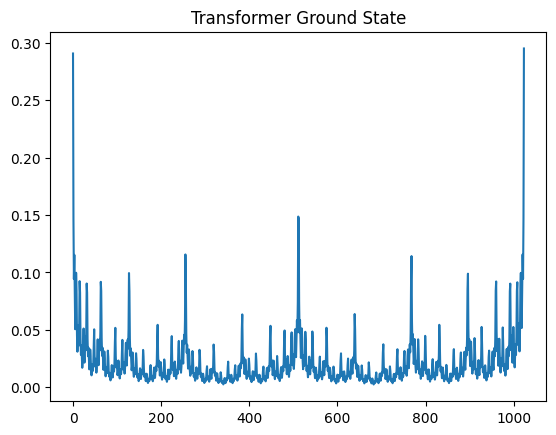

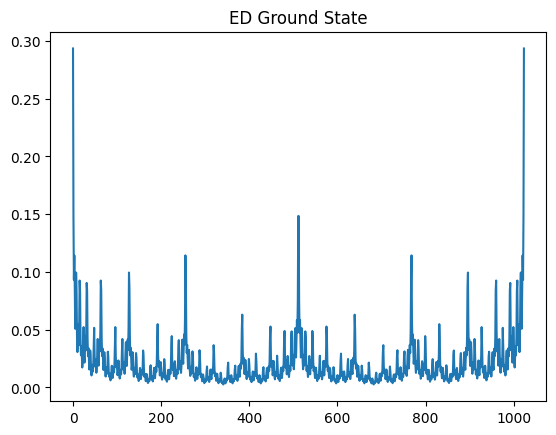

In [9]:
"""
Do we want to check this all works on a small system size
Run this whenever a change is made to confirm that in the trivial case, the 
"""
check_eloc = True

if check_eloc:
    
    def local_energy_function(states, decoder):
        return tfim_E_loc(
            J=-1, 
            g=-1, 
            configuration=states, 
            decoder=decoder, 
            scrambled=False
        )

    embedding_dimension=15
    
    test_learning_rate = CustomSchedule(
        d_model=embedding_dimension, 
        warmup_steps=250, 
        final_step = 1000, 
        minimum_step_size = 0.001,
    )

    test_optimizer = tf.keras.optimizers.legacy.Adam(
        test_learning_rate, 
        beta_1=0.9, 
        beta_2=0.98, 
        epsilon=1e-9,
    )
    
    test_sequence_length=10+1

    test_decoder=TransformerDecoder( 
        num_heads=2, 
        key_dim=embedding_dimension, 
        value_dim=embedding_dimension, 
        embedding_dim=embedding_dimension, 
        dictionary_size=2,
        decoding_reps=2, 
        width=15, 
        depth=2,
        name=None,
        sequence_length=test_sequence_length,
        dropout=0,
        attention_dropout=0,
        final_temperature=1,
    )
    
    initial_training_reps = 1000
    Ns=50
    
    test_real_energies = []
    test_imag_energies = []

    check_eloc_progress_bar = tqdm.tqdm(total=initial_training_reps, unit=' steps', ncols=100)

    for current_training_rep in range(initial_training_reps):

        derivatives, (e_real, e_imag) = test_decoder.evaluate_gradients(Ns, local_energy_function, reps=1)

        test_optimizer.apply_gradients(zip(derivatives, test_decoder.trainable_weights))

        test_real_energies.append(e_real)
        test_imag_energies.append(e_imag)
        
        if current_training_rep%5==0 and current_training_rep>0:
            check_eloc_progress_bar.set_description(f"Loss: {np.mean(test_real_energies[-5:]):.4f}")
        
        check_eloc_progress_bar.update(1)
    """
    compute overlap with exact ground state
    """
    check_eloc_progress_bar.close()
    
    print("comparing to exact diagonalization")

    tfim_ham = cirq.PauliSum()

    for i in range(9):
        tfim_ham+= -1*cirq.Z(cirq.LineQubit(i))*cirq.Z(cirq.LineQubit(i+1))

    for i in range(10):
        tfim_ham+= -1*cirq.X(cirq.LineQubit(i))
    
    ham_mat = tfim_ham.matrix()

    ws, vs = LA.eigh(ham_mat)

    gs = get_explicit_transformer_state(
        test_decoder,
        qubit_num=10,
        assert_real=True,
    )

    overlap = np.abs(np.sum(gs*vs[:, 0]))
    
    print(f"overlap: {overlap}")
    
    plt.plot(np.abs(gs))
    plt.title("Transformer Ground State")
    plt.show()
    
    plt.plot(np.abs(vs[:, 0]))
    plt.title("ED Ground State")
    plt.show()
    
    # free up any space this may have taken
    #del test_decoder

# training the model

In [10]:
embedding_dimension=15
sequence_length=100+1

params = {
    "num_heads": 1, 
    "key_dim": embedding_dimension, 
    "value_dim": embedding_dimension, 
    "embedding_dim": embedding_dimension, 
    "dictionary_size": 2,
    "decoding_reps": 1, 
    "width": None, 
    "depth": 2,
    "sequence_length": sequence_length,
}

In [11]:
"""
We choose a random seed for this initialization
"""
seed = 1

In [12]:
name = f"modified_training_length_100_tfim_seed_{seed}_extremely_simple_model"

with open(f"params_{name}.json", "w") as outfile:
    json.dump(params, outfile)

In [13]:
tf.random.set_seed(seed=seed)

decoder=TransformerDecoder(
    **params
)

In [14]:
print("number of params: ", np.sum([np.prod(array.shape) for array in decoder.trainable_weights]))

number of params:  1099


In [15]:
def local_energy_function(states, decoder):
    return tfim_E_loc(
        J=-1, 
        g=-1, 
        configuration=states, 
        decoder=decoder, 
        scrambled=False
    )

In [16]:
learning_rate = CustomSchedule(
    d_model=embedding_dimension, 
    warmup_steps=400, 
    final_step = 2000, 
    minimum_step_size = 10**-4,
)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.99, epsilon=1e-9)

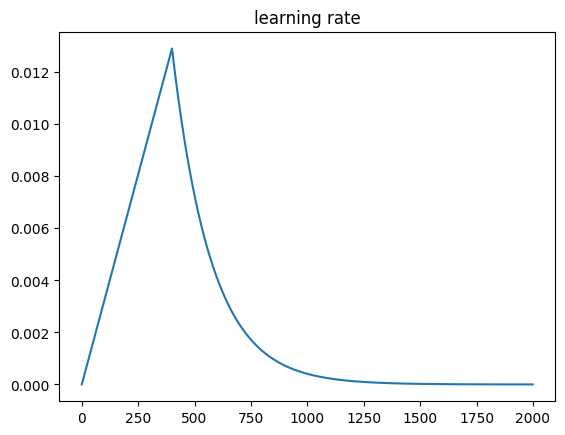

In [17]:
plt.plot([learning_rate(float(n)) for n in range(2000)])
plt.title("learning rate")
plt.show()

In [18]:
real_energies = []
imag_energies = []

In [19]:
Ns=50

progress_bar = tqdm.tqdm(total=learning_rate.final_step, unit=' steps', ncols=100)

for idx in range(learning_rate.final_step):
    
    derivatives, (e_real, e_imag) = decoder.evaluate_gradients(Ns, local_energy_function)
    
    optimizer.apply_gradients(zip(derivatives, decoder.trainable_weights))
    
    real_energies.append(e_real)
    imag_energies.append(e_imag)
    
    if idx%5==0 and idx>0:
        progress_bar.set_description(f"Loss: {np.mean(real_energies[-5:]):.4f}")
    
    if idx%50==0:
        np.save(f"{name}.npy", np.array(list(zip(real_energies, imag_energies)), dtype=np.complex128))
        decoder.save_weights(name)
    progress_bar.update(1)

progress_bar.close()

np.save(f"{name}.npy", np.array(list(zip(real_energies, imag_energies)), dtype=np.complex128))
decoder.save_weights(name)

Loss: -126.9013: 100%|██████████████████████████████████████| 2000/2000 [27:51<00:00,  1.20 steps/s]


In [20]:
energy = []
for rep in range(10):
    initial_states = np.zeros((50, 1))
    
    samples, log_probs, phases = decoder.autoregressive_sampling(
        initial_states
    )
    
    er, ei = local_energy_function(samples, decoder)
    
    energy.append(er)

In [21]:
np.mean(energy), np.std(energy, ddof=1)

(-126.88507, 0.46241045)

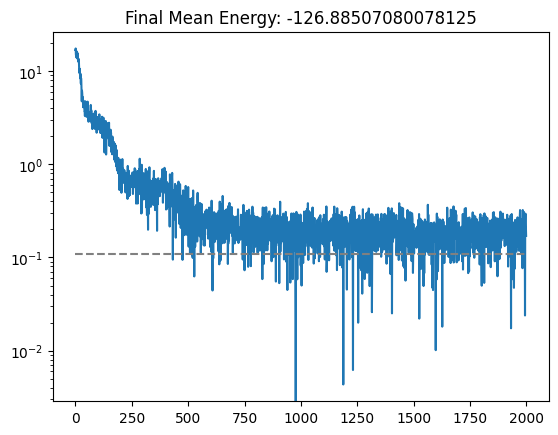

In [22]:
plt.plot(np.array(real_energies)-np.min(np.array(real_energies)))
plt.hlines(-126.96187673950975 -np.min(np.array(real_energies)),0, len(real_energies) , linestyle='dashed', color='grey')
plt.title(f"Final Mean Energy: {np.mean(energy)}")
plt.yscale('log')